<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s12/S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torchvision.datasets as datasets
from PIL import Image
from read_inputs import read_transform_inputs
from utility_fun import *
import matplotlib.pyplot as plt
from gradcam.visualize import VisualizeCam
from train import *
from lrtest.lr_range_test import LRRangeFinder
from lrtest.lr_cycle_plot import LRCyclePlot
from torch.optim import lr_scheduler
from model.model import BasicBlock,Bottleneck,ResNet

  pip install torch-lr-finder -v --global-option="amp"


In [ ]:
data_dir = "D:\\Assignment_ML_Engineer\\EVA_4.0\\S12\\data\\tiny-imagenet-200\\"

In [ ]:
def normalize_tin_val_folder_structure(path,
                                       images_folder='images',
                                       annotations_file='val_annotations.txt'):
    # Check if files/annotations are still there to see
    # if we already run reorganize the folder structure.
    images_folder = os.path.join(path, images_folder)
    annotations_file = os.path.join(path, annotations_file)

    # Exists
    if not os.path.exists(images_folder) \
       and not os.path.exists(annotations_file):
        if not os.listdir(path):
            raise RuntimeError('Validation folder is empty.')
        return

    # Parse the annotations
    with open(annotations_file) as f:
        for line in f:
            values = line.split()
            img = values[0]
            label = values[1]
            img_file = os.path.join(images_folder, values[0])
            label_folder = os.path.join(path, label)
            os.makedirs(label_folder, exist_ok=True)
            try:
                shutil.move(img_file, os.path.join(label_folder, img))
            except FileNotFoundError:
                continue

    #os.sync()
    assert not os.listdir(images_folder)
    shutil.rmtree(images_folder)
    os.remove(annotations_file)
    #os.sync()

In [ ]:
#normalize_tin_val_folder_structure(path = "D:\\Assignment_ML_Engineer\\EVA_4.0\\S12\\data\\tiny-imagenet-200\\val",images_folder = 'images',annotations_file='val_annotations.txt')

In [ ]:
data_transforms = { 'train': transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor()]),
                    'val'  : transforms.Compose([transforms.ToTensor(),]) }
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
show_model_summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(trainloader),
                       epochs=30, div_factor=10, final_div_factor=10,
                       pct_start=10/30)
trainloader = dataloaders['train']
testloader = dataloaders['val']

In [ ]:
clf = training_class(model = model,trainloader = trainloader, testloader = testloader, device = device, epoch= 30, optimizer = optimizer, criterion = criterion ,l1 = 3e-6 , l2 = 1e-3,scheduler=scheduler)
train_acc,test_acc = clf.fit()

epoch [0] train accuracy 0.173 : test accuracy 0.167
epoch [1] train accuracy 0.269 : test accuracy 0.253
epoch [2] train accuracy 0.338 : test accuracy 0.311
epoch [3] train accuracy 0.396 : test accuracy 0.360
epoch [4] train accuracy 0.436 : test accuracy 0.397
epoch [5] train accuracy 0.473 : test accuracy 0.414
epoch [6] train accuracy 0.507 : test accuracy 0.442
epoch [7] train accuracy 0.534 : test accuracy 0.451
epoch [8] train accuracy 0.557 : test accuracy 0.462
epoch [9] train accuracy 0.580 : test accuracy 0.471
epoch [10] train accuracy 0.612 : test accuracy 0.487
epoch [11] train accuracy 0.633 : test accuracy 0.497
epoch [12] train accuracy 0.664 : test accuracy 0.504
epoch [13] train accuracy 0.681 : test accuracy 0.509
epoch [14] train accuracy 0.707 : test accuracy 0.514
epoch [15] train accuracy 0.723 : test accuracy 0.504
epoch [16] train accuracy 0.745 : test accuracy 0.509
epoch [17] train accuracy 0.769 : test accuracy 0.505
epoch [18] train accuracy 0.802 : test

In [ ]:
##Test Loop
testloss,test_check =  truth_checker(model, testloader, device,criterion)

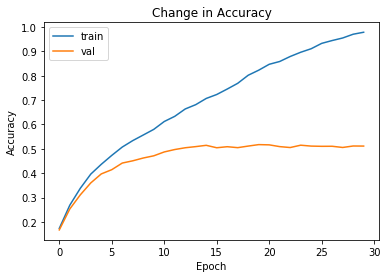

In [ ]:
plt_data = {
    "train": train_acc,
    "val": test_acc
}
plot_graph(plt_data, "Accuracy")